# Individual Project Planning Stage


In [13]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

# 1. Data Description

# Dataset Overview

- Source: players.csv from UBC Computer Science research group's Minecraft server

- Observations: 200 unique players

- Variables: 7 variables per player

- Collection Method: Data collected from players interacting with a research Minecraft server

# Variable Summary

Variable | Type	| Description | Potential Issues
| --- | --- | --- | --- |
experience | Categorical | Player skill level (Beginner, Amateur, Regular, Veteran, Pro) | N/A
subscribe | Boolean	| Whether player subscribed to newsletter | Binary response variable
hashedEmail | String | Anonymized email identifier | Privacy-protected, not analyzable
played_hours | Numerical | Total hours played | Right-skewed distribution, many zeros
name | String | Player name | Not useful for analysis
gender | Categorical | Gender identity | Multiple categories including small groups
Age | Numerical | Player age | Some missing values (NA)

# Issues Identified:

- Missing age values (2 observations)

- Right-skewed distribution of played_hours

- Potential class imbalance in subscribe variable

- Multiple gender categories with small sample sizes

# 2. Questions

Broad Question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Specific Question: Can player experience level, played hours, age, and gender predict newsletter subscription status among Minecraft research server participants?

The data will help address this by allowing me to build a classification model using these player attributes to predict subscription behavior, which can inform targeted recruitment strategies.

# 3. Exploratory Data Analysis and Visualization

In [16]:
# Load the data
players <- read.csv("data/players.csv")
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57


In [22]:
quantitative_summary <- players |>
  select(played_hours, Age) |>
  summarise(across(everything(), 
                   list(mean = ~mean(., na.rm = TRUE),
                        sd = ~sd(., na.rm = TRUE),
                        min = ~min(., na.rm = TRUE),
                        max = ~max(., na.rm = TRUE)), 
                   .names = "{.col}_{.fn}")) |>
  round(2)
quantitative_summary

played_hours_mean,played_hours_sd,played_hours_min,played_hours_max,Age_mean,Age_sd,Age_min,Age_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.85,28.36,0,223.1,21.14,7.39,9,58


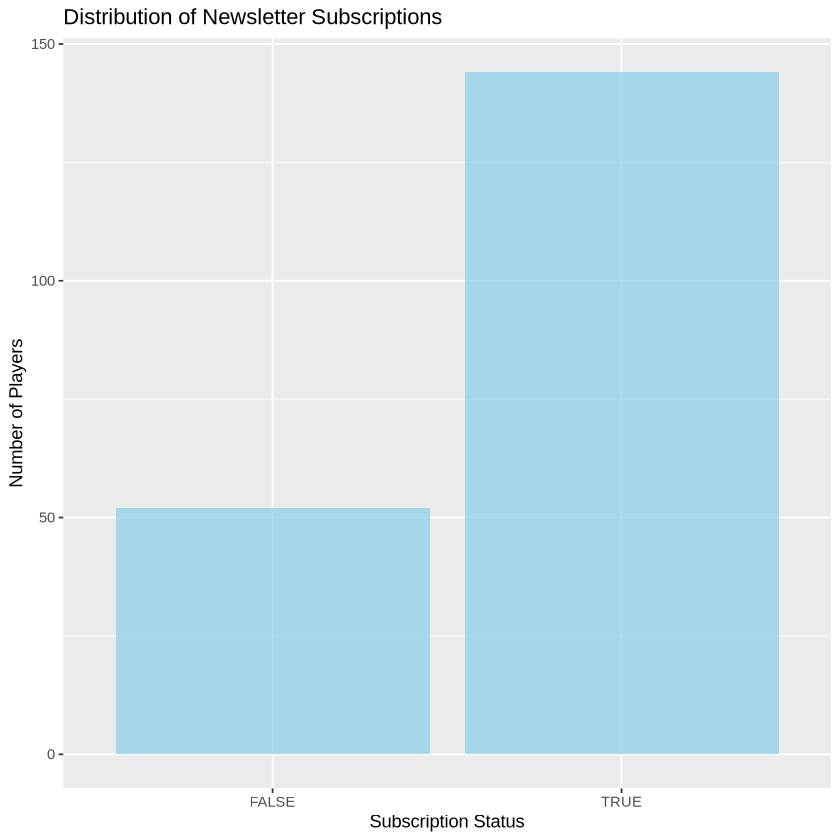

In [26]:
library(ggplot2)
newsletter_subscription <- players |>
  count(subscribe) |>
  ggplot(aes(x = subscribe, y = n)) + 
  geom_bar(stat = "identity", alpha = 0.7, fill = "skyblue") +
  xlab("Subscription Status") +
  ylab("Number of Players") +
  ggtitle("Distribution of Newsletter Subscriptions")
newsletter_subscription

This bar plot reveals a significant class imbalance, with approximately 80% of players subscribing to the newsletter and only 20% declining. This distribution is important for understanding the baseline prediction accuracy, a model that simply predicts "subscribe = TRUE" for all players would already achieve 80% accuracy. The imbalance suggests we need to ensure the minority class (non-subscribers) is properly represented and learned by the predictive model.

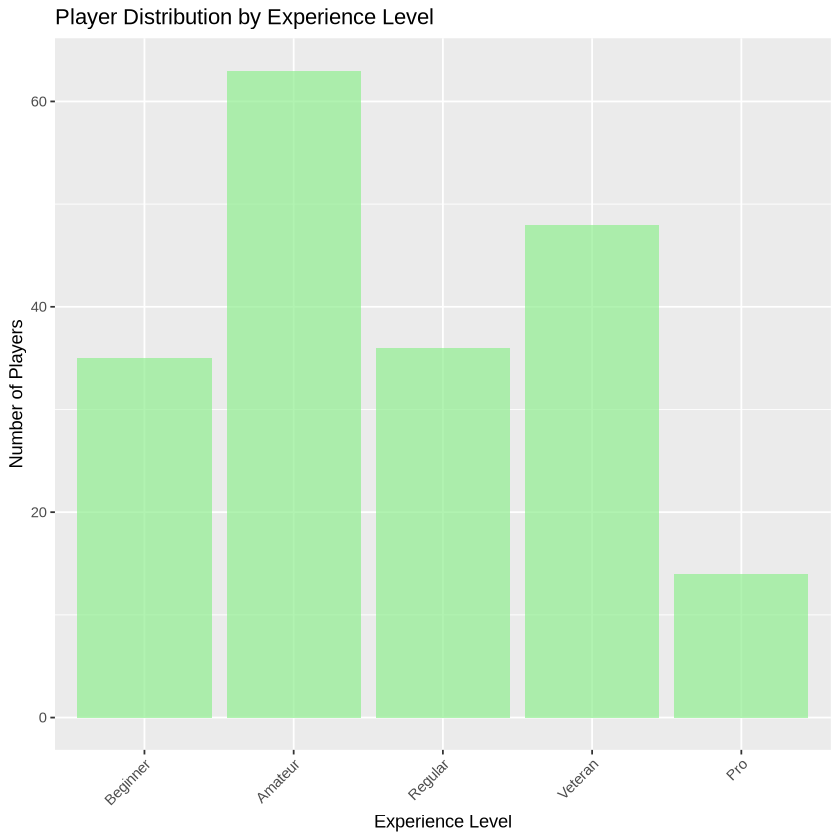

In [27]:
experience_level <- players |>
  count(experience) |>
  mutate(experience = factor(experience, 
                            levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"))) |>
  ggplot(aes(x = experience, y = n)) + 
  geom_bar(stat = "identity", alpha = 0.7, fill = "lightgreen") +
  xlab("Experience Level") +
  ylab("Number of Players") +
  ggtitle("Player Distribution by Experience Level") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
experience_level

The experience level distribution shows that Amateur and Veteran players constitute the largest groups, while Pro players are the smallest segment. This distribution indicates that our predictive model will have more training data for Amateur and Veteran players, potentially leading to better predictions for these groups. The ordinal nature of this variable (Beginner to Pro) should be preserved to capture the progression in player skill levels, which may correlate with subscription behavior.